# Prediction of individual sequences : home assignment

## Part 2. Experiments – predict votes of surveys

### Student : Yonatan DELORO

### Contact : yonatan.deloro@eleves.enpc.fr

## 1. Necessary preprocessing

(removing " in politicians_id.csv file)

In [89]:
#to do in command line
#sed -i 's/"//g' politicians_id.csv

## 2. Imports

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## 3. Store the data in dataframes and choose the dataset on study

In [91]:
dfs = {}
datas = ["ideas","politicians"]
tables = ["id","votes"]
for data in datas:
    dfs[data] = {}
    folder = data+"_dataset"
    for table in tables:
        dfs[data][table] = pd.read_csv(folder+"/"+data+"_"+table+".csv",index_col=0)

In [92]:
name = "politicians"
display(dfs[name]["id"])
#display(dfs["ideas"]["id"])

,politician.text
politician.id,
1,Rep. Alan Mollohan
2,Sen. Mitch McConnell
3,Elizabeth Birnbaum
4,Rep. Artur Davis
5,Organized labor
6,Rep. Joe Barton
7,Gen. John Petraeus
8,Robert Gibbs
9,Tom Vilsack


In [93]:
display(dfs[name]["votes"])
#display(dfs["ideas"]["votes"])

,z1,z2,y
round,,,
1,20,5,0
2,5,16,0
3,7,22,0
4,1,15,0
5,9,5,0
6,1,21,1
7,17,7,0
8,18,11,1
9,5,6,1


In [94]:
def read_data(t):
    #return index of player1, index of player 2 and boolean for win of player1
    #at round t
    data_t = dfs[name]["votes"].loc[t]
    player1 = data_t["z1"] - 1 #-1 since indices begin at 0 in python, and we will store experts weights in an array
    player2 = data_t["z2"] - 1
    player1_won = data_t["y"]
    return player1, player2, player1_won

def loss(y_pred,y_obs):
    #compute the loss given the predicted probability of win y_pred
    #and the boolean y_obs indicating if player 1 won
    return (1-y_pred)*y_obs + y_pred*(1-y_obs)

nb_players = dfs[name]["id"].shape[0]
#number of different players competing
    
nb_experts = 2*nb_players 
#expert e will predict always the win of player e
#expert nb_players+e will predict always the loss of player e
print(nb_experts)

T = 15000 #number of rounds

78


## 4. Random Forecaster

In [95]:
class Random():
    
    def __init__(self):
        self.total_loss = 0 
        pass
    
    def play_until(self, T, return_history_loss=False):  
        #if return_history_loss is True,
        #returns the history of expected and true losses at each round
        
        if return_history_loss:
            history_expected_loss = np.zeros(T)
            history_true_loss = np.zeros(T)
            
        for t in range(1,T+1):
            
            player1, player2, player1_won = read_data(t)
            proba_player1_won = np.random.rand() #predicted probability of win
            
            algo_loss = loss(proba_player1_won, player1_won)
            self.total_loss += algo_loss
            
            if return_history_loss: 
                history_expected_loss[t-1] = algo_loss
                
                player1_won_predicted = 0  #voting according to the predicted probability
                if np.random.rand()<proba_player1_won:
                    player1_won_predicted = 1
                history_true_loss[t-1] = player1_won_predicted != player1_won
                
        if return_history_loss:
            return history_expected_loss, history_true_loss

## 5. EWA Forecaster

In [96]:
class EWA():
    
    #Exponentially Weighted Average Forecaster
    
    def __init__(self, eta=0.1):
        
        self.eta = eta
        self.weights = 1/nb_experts * np.ones(nb_experts) #weights of experts
        self.sum_losses = np.zeros(nb_experts) #sum of losses for each expert
        self.total_loss = 0 #cumulative loss
    
    def play_until(self, T, return_history_loss=False):  
        #if return_history_loss is True,
        #returns the history of expected and true losses at each round
        
        if return_history_loss:
            history_expected_loss = np.zeros(T)
            history_true_loss = np.zeros(T)
        
        for t in range(1,T+1):

            #reads data
            player1, player2, player1_won = read_data(t)
            
            #weighted prediction that player 1 will win
            #since expert e predicts always the win of player e, and expert nb_players+e its defeat
            num = self.weights[player1] + self.weights[player2 + nb_players] 
            denum = num + self.weights[player2] + self.weights[player1 + nb_players]
            if denum>0:
                proba_player1_won = num / denum 
            else: #happens only if eta is too large 
                proba_player1_won = 0.5
                
            #compute algorithm loss
            algo_loss = loss(proba_player1_won, player1_won)
            
            if return_history_loss: 
                
                history_expected_loss[t-1] = algo_loss
                
                #voting for the player1's win the estimated probability
                player1_won_predicted = 0 
                if np.random.rand()<proba_player1_won:
                    player1_won_predicted = 1
                history_true_loss[t-1] = player1_won_predicted != player1_won
                
            self.total_loss += algo_loss

            #incurring loss to each expert
            
            #for experts sleeping, we incurr the weighted sum of losses of non sleeping experts,
            #or in other words the algorithm loss (linear loss function)
            new_losses = algo_loss*np.ones(nb_experts)
            #for non sleeping experts, we incurr their own loss 
            #(expert e predicts always the win of player e, and expert nb_players+e its defeat)
            loss1 = loss(1,player1_won)
            loss2 = loss(0,player1_won)
            new_losses[player1] = loss1
            new_losses[player2] = loss2
            new_losses[player1 + nb_players] = loss2
            new_losses[player2 + nb_players] = loss1

            #update sum of experts lossses
            self.sum_losses += new_losses

            #update weights
            self.weights = np.exp(-self.eta * self.sum_losses)
            
            #we do not need to normalize as we will normalize by the sum of the weights of the non sleeping experts
            #at next iteration
            #self.weights /= np.sum(self.weights)
            
        if return_history_loss:
            return history_expected_loss, history_true_loss

## 6. OGD Forecaster

In [97]:
def gradient_loss(y_pred,y_obs): 
    #with respect to the expert weight
    #y_pred is the prediction of the expert for player1's win, and y_obs the boolean indicating if it won
    return y_pred*(1-2*y_obs)

def projection_simplex(v):
    #I implemented the linear time projection algorithm onto the simplex designed in the article below :
    #https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf (pivot method)
    U = list(range(v.shape[0]))
    s = 0
    rho = 0
    while len(U)!=0:
        idx_pivot = np.random.choice(U)
        G = []
        L = []
        delta_s = v[idx_pivot]
        for idx in U:
            if idx!=idx_pivot:
                if v[idx]>v[idx_pivot]:
                    G.append(idx)
                    delta_s += v[idx]
                else:
                    L.append(idx)
        delta_rho = len(G) + 1 #1 for v[idx_pivot]
        if (s+delta_s) < 1 + (rho + delta_rho)*v[idx_pivot]:
            s += delta_s
            rho += delta_rho
            U = L
        else:
            U = G
    theta = (s-1)/rho
    res = v-theta
    res[res<0] = 0
    return res

In [98]:
class OGD():
    
    #Online Gradient Descent Forecaster
    
    def __init__(self, eta=0.1):
        
        self.eta = eta
        self.weights = 1/nb_experts * np.ones(nb_experts) #weights of experts
        self.total_loss = 0 #cumulative loss
    
    def play_until(self, T, return_history_loss=False):  
        
        if return_history_loss:
            history_expected_loss = np.zeros(T)
            history_true_loss = np.zeros(T)
        
        for t in range(1,T+1):

            #reads data
            player1, player2, player1_won = read_data(t)
            
            #weighted prediction that player 1 will win
            #since expert e predicts always the win of player e, and expert nb_players+e its defeat
            num = self.weights[player1] + self.weights[player2 + nb_players] 
            denum = num + self.weights[player2] + self.weights[player1 + nb_players]
            if denum>0:
                proba_player1_won = num / denum
            else: #happens only if eta is too large 
                proba_player1_won = 0.5
            
            #compute algorithm loss
            algo_loss = loss(proba_player1_won, player1_won)
            
            if return_history_loss: 
                
                history_expected_loss[t-1] = algo_loss
                
                #voting for the player1's win the estimated probability
                player1_won_predicted = 0 
                if np.random.rand()<proba_player1_won:
                    player1_won_predicted = 1
                history_true_loss[t-1] = player1_won_predicted != player1_won
                
            self.total_loss += algo_loss
            
            #incurring loss to each expert
            
            #for experts sleeping, we can incurr to them the gradient loss of the algorithm prediction
            grad_loss_sleeping = gradient_loss(proba_player1_won,player1_won) 
            self.weights -= self.eta*grad_loss_sleeping 
            #(note : we will re-add self.eta*grad_loss_sleeping for non sleeping experts)

            #for non sleeping experts, incurring the gradient loss of their prediction
            grad_loss1 = gradient_loss(1,player1_won) 
            self.weights[player1] -= self.eta*(grad_loss1-grad_loss_sleeping)  
            self.weights[player2 + nb_players] -= self.eta*(grad_loss1-grad_loss_sleeping)
            #grad_loss2 = gradient_loss(0,player1_won) = 0
            self.weights[player2] += self.eta*grad_loss_sleeping
            self.weights[player1 + nb_players] += self.eta*grad_loss_sleeping

            #projecting on the simplex the weights vector
            self.weights = projection_simplex(self.weights)
            

        if return_history_loss:
            return history_expected_loss, history_true_loss

## 7. PROD Forecaster

In [99]:
class PROD():
    
    #Prod Forecaster
    
    def __init__(self, eta):
        
        self.etas = eta
        self.prods = np.ones(nb_experts)
        self.total_loss = 0 #cumulative loss
    
    def play_until(self, T, return_history_loss=False):  
        
        if return_history_loss:
            history_expected_loss = np.zeros(T)
            history_true_loss = np.zeros(T)
        
        for t in range(1,T+1):

            #reads data
            player1, player2, player1_won = read_data(t)
            
            #weighted prediction that player 1 will win
            #since expert e predicts always the win of player e, and expert nb_players+e its defeat
            num = self.etas[player1]*self.prods[player1] + self.etas[player2 + nb_players]*self.prods[player2 + nb_players] 
            denum = num + self.etas[player2]*self.prods[player2] + self.etas[player1 + nb_players]*self.prods[player1 + nb_players]
            if denum>0:
                proba_player1_won = num / denum
            else: #happens only for large eta
                proba_player1_won = 0.5
            
            #compute algo loss
            algo_loss = loss(proba_player1_won, player1_won)

            if return_history_loss: 
                
                history_expected_loss[t-1] = algo_loss
                
                #voting for the player1's win the estimated probability
                player1_won_predicted = 0 
                if np.random.rand()<proba_player1_won:
                    player1_won_predicted = 1
                history_true_loss[t-1] = player1_won_predicted != player1_won
                
            self.total_loss += algo_loss
            
            #update prods (incurring loss)
            self.prods[player1] *= 1 + self.etas[player1]*(algo_loss-loss(1,player1_won))
            self.prods[player2] *= 1 + self.etas[player2]*(algo_loss-loss(0,player1_won))
            self.prods[player1 + nb_players] *= 1 + self.etas[player1 + nb_players]*(algo_loss-loss(0,player1_won))
            self.prods[player2 + nb_players] *= 1 + self.etas[player2 + nb_players]*(algo_loss-loss(1,player1_won))
                    
        if return_history_loss:
            return history_expected_loss, history_true_loss

## 8. Results

## 8.1. Impact of eta parameter for each algorithm

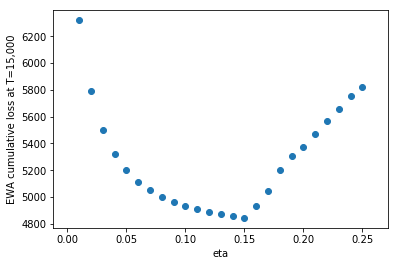

best eta :  0.15000000000000002


In [100]:
if name == "ideas": etas = [math.pow(10,-i) for i in range(0,5)] #only coarse grid search for ideas (more time consuming)
else: etas = np.linspace(0.01,0.25,25) #fine grid search for politicians
size_grid = np.shape(etas)[0]
cumul_losses_ewa = np.zeros(size_grid)
for idx in range(size_grid):
    EWA_eta = EWA(eta=etas[idx])
    EWA_eta.play_until(T)
    cumul_losses_ewa[idx] = EWA_eta.total_loss
if name == "ideas": plt.xscale('log') 
plt.scatter(etas,cumul_losses_ewa)
plt.xlabel("eta") ; plt.ylabel("EWA cumulative loss at T=15,000")
plt.show()

eta_ewa_opt = etas[np.argmin(cumul_losses_ewa)]
print("best eta : ",eta_ewa_opt)

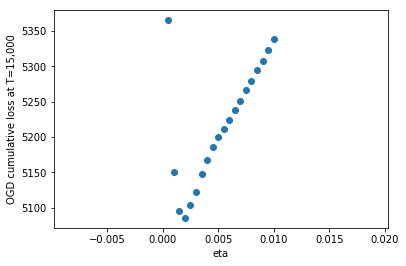

best eta :  0.002


In [101]:
if name == "ideas": etas = [math.pow(10,-i) for i in range(2,6)] #coarse grid search for ideas
else: etas = np.linspace(0.0005,0.01,20) #fine grid search for politicians
size_grid = len(etas)
cumul_losses_ogd = np.zeros(size_grid)
for idx in range(size_grid):
    OGD_eta = OGD(eta=etas[idx])
    OGD_eta.play_until(T)
    cumul_losses_ogd[idx] = OGD_eta.total_loss
if name == "ideas": plt.xscale('log') 
plt.scatter(etas,cumul_losses_ogd)
plt.xlabel("eta") ; plt.ylabel("OGD cumulative loss at T=15,000")
plt.show()

eta_ogd_opt = etas[np.argmin(cumul_losses_ogd)]
print("best eta : ", eta_ogd_opt)

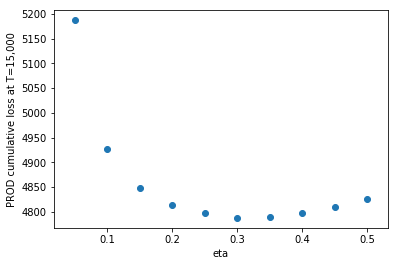

best eta :  0.3


In [102]:
if name == "ideas": etas = [math.pow(10,-i) for i in range(0,5)] #coarse grid search for ideas
else: etas = np.linspace(0.05,0.5,10) #fine grid search for politicians
size_grid = np.shape(etas)[0]
cumul_losses_prod = np.zeros(size_grid)
for idx in range(size_grid):
    Prod_eta = PROD(eta=etas[idx]*np.ones(nb_experts))
    Prod_eta.play_until(T)
    cumul_losses_prod[idx] = Prod_eta.total_loss
if name == "ideas": plt.xscale('log') 
plt.scatter(etas,cumul_losses_prod)
plt.xlabel("eta") ; plt.ylabel("PROD cumulative loss at T=15,000")
plt.show()

eta_prod_opt = etas[np.argmin(cumul_losses_prod)]
print("best eta : ", eta_prod_opt)

In [103]:
#theoretical values

eta_ewa_theor =  np.sqrt(np.log(nb_experts)/(nb_experts*T)) 
eta_ogd_theor = 1/np.sqrt(T)

print("best eta : ",eta_ewa_theor,eta_ogd_theor)

best eta :  0.0019296846265269233 0.00816496580927726


## 8.2. Comparison between Forecasters : cumulated loss, average expected loss and average true loss evolutions

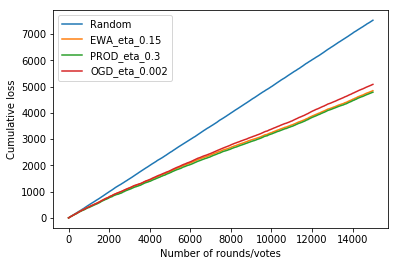

Random  Convergence of avg expected loss towards : 0.502
EWA_eta_0.15  Convergence of avg expected loss towards : 0.323
PROD_eta_0.3  Convergence of avg expected loss towards : 0.319
OGD_eta_0.002  Convergence of avg expected loss towards : 0.339


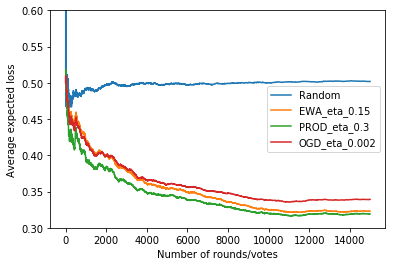

In [105]:
empirical_etas = True #using best etas found empirically if True (if False, using theoretical values)

if empirical_etas:
    algos = {'Random' : Random(), 
             'EWA_eta_'+str(round(eta_ewa_opt,4)) : EWA(eta=eta_ewa_opt), 
             'OGD_eta_'+str(round(eta_ogd_opt,4)) : OGD(eta=eta_ogd_opt),  
             'PROD_eta_'+str(round(eta_prod_opt,4)) : PROD(eta=eta_prod_opt*np.ones(nb_experts))}

else:
    algos = {'Random' : Random(), 
             'EWA_eta_theor_'+str(round(eta_ewa_theor,4)) : EWA(eta=eta_ewa_theor), 
             'OGD_eta_theor_'+str(round(eta_ogd_theor,4)) : OGD(eta=eta_ogd_theor)}


history_expected_loss = {}
history_true_loss = {}

for (name_algo,algo) in algos.items():
    expected_loss, true_loss = algo.play_until(T, return_history_loss=True)
    history_expected_loss[name_algo] = expected_loss
    history_true_loss[name_algo] = true_loss
    
for name_algo in algos.keys():
    plt.plot(np.cumsum(history_expected_loss[name_algo]), label=name_algo)
plt.xlabel("Number of rounds/votes")
plt.ylabel("Cumulative loss")
plt.legend()
plt.show()

for name_algo in algos.keys():
    hist = np.cumsum(history_expected_loss[name_algo])/np.arange(1,T+1)
    print(name_algo, " Convergence of avg expected loss towards :",round(hist[-1],3))
    plt.ylim(top=0.6,bottom=0.3) 
    plt.plot(hist, label=name_algo)
plt.xlabel("Number of rounds/votes")
plt.ylabel("Average expected loss")
plt.legend()
plt.show()

Random  Convergence of avg true loss towards : 0.505
EWA_eta_0.15  Convergence of avg true loss towards : 0.318
PROD_eta_0.3  Convergence of avg true loss towards : 0.318
OGD_eta_0.002  Convergence of avg true loss towards : 0.339


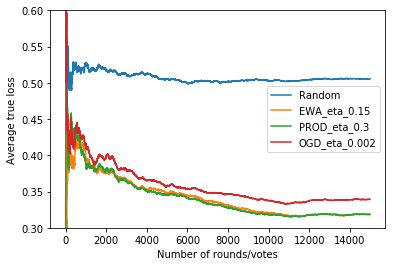

In [107]:
for name_algo in algos.keys():
    hist = np.cumsum(history_true_loss[name_algo])/np.arange(1,T+1)
    print(name_algo, " Convergence of avg true loss towards :",round(hist[-1],3))
    plt.ylim(top=0.6,bottom=0.3) 
    plt.plot(hist, label=name_algo)
plt.xlabel("Number of rounds/votes")
plt.ylabel("Average true loss")
plt.legend()
plt.show()